# Experiment 3 - Scene Splitting

In [1]:
%matplotlib notebook
from math import sqrt
import numpy as np
import scipy
import glob
import cv2
import matplotlib
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize as imresize
from bitstring import BitArray, BitStream

##### Support Functions

In [2]:
# implement 2D DCT
def dct2(img):
    from scipy.fftpack import dct
    return dct(dct(img.T, norm='ortho').T, norm='ortho')

# implement 2D IDCT
def idct2(img):
    from scipy.fftpack import idct
    return idct(idct(img.T, norm='ortho').T, norm='ortho')   

def diag_gen(nsides):
    x, y = 0, 0
    upright = True
    visits = 1
    while visits <= nsides**2:
        yield (x,y)
        visits += 1
        if upright:
            x, y = x - 1, y + 1
        else:
            x, y = x + 1, y - 1
        #yield (0, x, y)
        if 0 <= x < nsides:
            if 0 <= y < nsides:
                continue
            elif 0 < y:
                x += 2
                y -= 1
            else:
                y = 0
        elif 0 < x:
            if 0 <= y < nsides:
                x -= 1
                y += 2
            elif 0 < y:
                raise Exception("this shouldn't happen ({}, {})".format(x, y))
            else:
                x -= 1
                y += 2
        else:
            if 0 <= y < nsides:
                x = 0
            elif 0 < y:
                x += 2
                y = nsides-1
            else:
                raise Exception("this shouldn't happen ({}, {})".format(x, y))
        upright = not upright

# Image Hasher

<IPython.core.display.Javascript object>


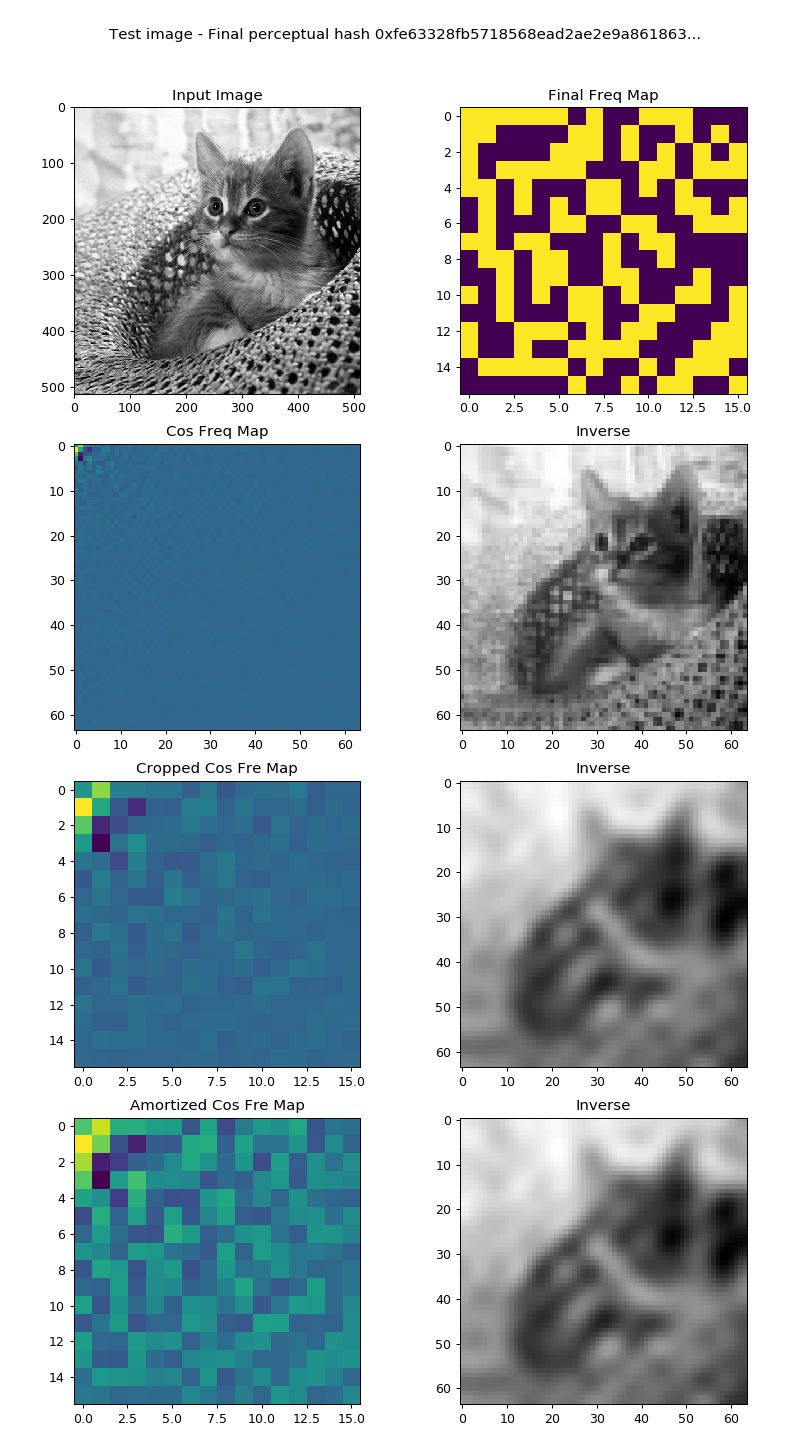

0xfe63328fb5718568ead2ae2e9a8618630a7559abd2554ab881c3e7c20c107fd9


In [119]:
# must be already grayscale
def img_to_hash(img_full, resizeTo=64, cropTo=16, plot=False):
    #img_full = rgb2gray(imread(src))
    img_base = imresize(img_full, (resizeTo,resizeTo))
    img_base -= 0.5
    
    img_freq = dct2(img_base)
    amortize = np.vectorize(lambda x: np.sign(x)*sqrt(abs(x)))
    img_freq_crop = img_freq[0:cropTo,0:cropTo]
    img_freq_amort = amortize(img_freq_crop)
    
    freq_avg = img_freq_amort.mean()
    f = lambda x: x > freq_avg
    img_freq_final = f(img_freq_amort)
    
    hash_val = "0b"
    for (x, y) in diag_gen(cropTo):
        hash_val += str(int(img_freq_final[x][y]))
    hash_val = BitArray(hash_val)
    
    if plot:
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(9,16))
        # The -5 and +5 were determined "experimentally"
        ax1.set_title('Input Image')
        ax1.imshow(img_full, cmap='gist_gray')
        ax2.set_title('Final Freq Map')
        ax2.imshow(img_freq_final)
        
        ax3.set_title('Cos Freq Map')
        ax3.imshow(img_freq)
        ax4.set_title('Inverse')
        ax4.imshow(idct2(img_freq), cmap='gist_gray')        
        
        ax5.set_title('Cropped Cos Fre Map')
        ax5.imshow(img_freq_crop)
        ax6.set_title('Inverse')
        img_freq_crop2 = np.zeros((resizeTo,resizeTo))
        img_freq_crop2[0:cropTo,0:cropTo] = img_freq_crop
        ax6.imshow(idct2(img_freq_crop2), cmap='gist_gray')
        
        ax7.set_title('Amortized Cos Fre Map')
        ax7.imshow(img_freq_amort)
        ax8.set_title('Inverse')
        img_freq_amort2 = np.zeros((resizeTo,resizeTo))
        invf = np.vectorize(lambda x: np.sign(x)*x**2)
        img_freq_amort2[0:cropTo,0:cropTo] = invf(img_freq_amort)
        ax8.imshow(idct2(img_freq_amort2), cmap='gist_gray')
        #ax8.imshow(img_freq_amort2)
    
        plt.tight_layout()
        plt.subplots_adjust(top=0.925)
        fig.suptitle('Test image - Final perceptual hash 0x{}...'.format(hash_val.hex[0:32]))
    
    return hash_val


hash_val = img_to_hash(rgb2gray(imread('../test-media/cat.png')), plot=True)
print(hash_val)

# Process Video

In [114]:
def hamming_dist(a,b):
    """Calculate the Hamming distance between two bit strings"""
    assert len(a.bin) == len(b.bin)
    count = 0
    return (a^b).count(1) #XOR

## Extract Frames

In [117]:
vidcap = cv2.VideoCapture('../test-media/vids/Caminandes_2-Z4C82eyhwgU.webm')
success,image = vidcap.read()
if not success:
    raise Exception("failed to open video")

last_hash = None
frames = []
frames_hash = []
while success:
    success, image = vidcap.read()
    if success:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        frames.append(image)
        hash_val = img_to_hash(image)
        if last_hash is not None:
            frames_hash.append(hamming_dist(last_hash, hash_val))
        last_hash = hash_val

## Plot Frame Hash over time

<IPython.core.display.Javascript object>


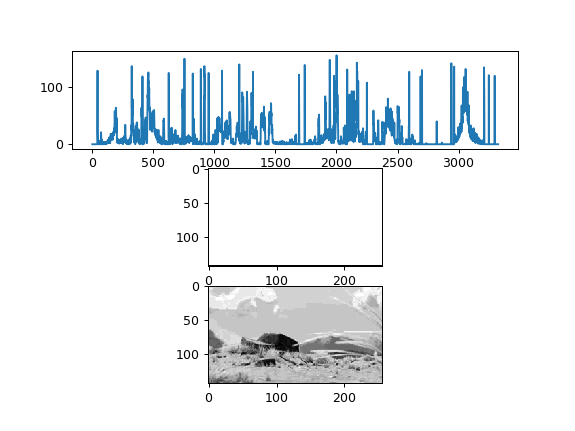

Min: 0
Avg: 13.93563909774436
STD: 22.943921348522647
max: 156


In [118]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
print("Min: {}".format(np.min(frames_hash)))
print("Avg: {}".format(np.mean(frames_hash)))
print("STD: {}".format(np.std(frames_hash)))
print("max: {}".format(np.max(frames_hash)))
ax1.plot(frames_hash)
ax2.imshow(frames[42], cmap='gist_gray')
ax3.imshow(frames[44], cmap='gist_gray')
fig.show()

In [ ]:
# alg for determining break pointslength/time.
# target_scene

Possible values for paramenters: target scene time $S_{tt} = 5\text{ min} = 300\text{ s}$, minimum scene length: $S_{\min t} = 10\text{ s}$.

Greedy algorithm for finding breakpoints: (time only)

1. $N_b = V_t/S_{tt}$ where $N_{tb}$ is the target number of breakpoints, $V_t$ is the video length/time, $S_{tt}$ scene target length/time.
2. For $0 <= i < N_{tb}$
    1. For each frame in order of hamming difference:
        1. If there is a near breakpoint, skip to the next candidate. (near is less then $S_{\min t}$, i.e. the minimum scene duration)
        2. Assign this frame as a new breakpoint.

Idealy, we would want something that tries to divide the video into scenes of "equal change" (i.e. equal sum of hamming distances) *and* equal length.

Better alg idea: (still suboptimal)

1. Use the cost function $c(f_0, f) = \int_{f_0}^f h_d(t) \text{d}t$ where $h_d(f)$ is the perceptual hash hamming distance between frame $f$ and $f-1$.
2. Compute the total video cost $C_v$ and the target scene cost $C_s = C_v/(V_t \times S_{tc})$ where $V_t$ is the video length/time, $S_{tc}$ scene target cost. (
3. For each frame $f$, make it a breakpoint if $c(f_0, f) \ge C_s$, where $f_0$ is the last breakpoint, and $f-f_0 \ge S_{\min t}$.